In [1]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import random
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import TrainingArguments, AutoTokenizer, HfArgumentParser
from utils.my_trainer import CustomTrainer
from utils.utils import my_compute_metrics,seed_everything
from typing import Optional
from dataclasses import dataclass, field
from utils.data_collator import MyDataCollatorForPPathVLM, MyDataCollatorForWPathVLM
from peft import LoraConfig
from datasets import load_dataset, concatenate_datasets
from utils.data_collator import MyDataCollatorForLanguageModelingTest

/bask/projects/p/phwq4930-gbm/Zeyu/asiw9691_conda_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'MyCustomModel' from 'model.my_model' (/bask/projects/p/phwq4930-gbm/Zeyu/PathVLM/source/PathLLM/model/my_model.py)

In [2]:
device = 'cuda'

def formatting_func(examples):
    question = examples["question"]
    answer = examples["answer"]
    if answer in ["yes","no"]:
        question += "Answer yes or no only!"
    text = f"<|Question|> {question}{tokenizer.eos_token}"
    examples["text"] = text
    return examples

def tokenize(element):
    outputs = tokenizer(
        element,
        add_special_tokens=True,
        truncation=True,
        padding=False,
        max_length=script_args.max_seq_length,
        return_overflowing_tokens=False,
        return_length=False,
    )

    return {"input_ids": outputs["input_ids"], "attention_mask": outputs["attention_mask"]}

seed_everything(42)

In [3]:
# set up tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
tokenizer.truncation_side = 'left'

new_tokens = ['<|Question|>',  '<|Answer|>', '<Image>']  # 你要添加的特殊字符列表
num_added_toks = tokenizer.add_tokens(new_tokens)
new_tokens_ids = tokenizer.convert_tokens_to_ids(new_tokens)
print("new_tokens_ids: ", new_tokens_ids)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


new_tokens_ids:  [128256, 128257, 128258]


In [4]:
# set up dataset
import ast

dataset_name_list = "CNX-PathLLM/PVQAClean" # CNX-PathLLM/PVQAClean CNX-PathLLM/TextbookQAPair
dataset = []
for dataset_name in dataset_name_list.split(","):
    dataset.append(load_dataset(dataset_name, split="train", cache_dir="/bask/projects/p/phwq4930-gbm/Zeyu/PathVLM/.cache"))
dataset = concatenate_datasets(dataset)
# dataset = dataset.filter(lambda x: x is not None, num_proc=20)
# for key in dataset.features.keys():
#     dataset = dataset.filter(lambda x: x[key] is not None, num_proc=20)
dataset = dataset.map(formatting_func, num_proc=20, remove_columns=["question"])
dataset = dataset.train_test_split(test_size=0.1)
dataset = dataset['test']

Repo card metadata block was not found. Setting CardData to empty.


In [5]:
device = 'cuda'
model = MyCustomModel(False, 
                      "conch",
                      False, 
                      False, 
                      "meta-llama/Meta-Llama-3-8B-Instruct", 
                      False, 
                      True, 
                      tokenizer,
                      new_tokens_ids[-1])

vision_encoder loading ...
llm loading ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:51<00:00, 12.79s/it]


In [6]:
from torch.utils.data import DataLoader

batch_size = 4  # 你可以根据需要调整批处理大小

data_collator = MyDataCollatorForLanguageModelingTest(tokenizer, model.image_processor)

In [7]:
def tokenize(element):
            outputs = tokenizer(
                # element[dataset_text_field] if not use_formatting_func else formatting_func(element),
                element,
                add_special_tokens=True,
                truncation=True,
                padding=False,
                max_length=256,
                return_overflowing_tokens=False,
                return_length=False,
            )

            return {"input_ids": outputs["input_ids"], "attention_mask": outputs["attention_mask"]}

tokenized_dataset = dataset.map(
            tokenize,
            batched=False,
            remove_columns=['text'],
            num_proc=4,
            batch_size=batch_size,
            input_columns=['text'],
       )

dataloader_params = {
            "batch_size": batch_size,
            "collate_fn": data_collator,
        }

eval_dataloader = DataLoader(tokenized_dataset, **dataloader_params)

Map (num_proc=4): 100%|██████████| 752/752 [00:01<00:00, 455.90 examples/s]


In [9]:
# params = torch.load("/bask/homes/a/asiw9691/PathVLM/source/PathLLM/PathClip_Mistral-7B_4dataset/checkpoint-750/global_step750/mp_rank_00_model_states.pt")
ckpt = "/bask/projects/p/phwq4930-gbm/Zeyu/PathVLM/source/PathLLM/Conch_Llama3ins_Instruct4/ckpt-850.bin"
model.load_state_dict(torch.load(ckpt, map_location=device))
model.to(device)

MyCustomModel(
  (vision_encoder): CoCa(
    (text): TextTransformer(
      (token_embedding): Embedding(32007, 768)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Identity()
          )
        )
      )
      (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (visual): VisualModel(
      (trunk): Visio

In [11]:
# 对于每个批次的数据
import numpy as np
from utils.eval_utils import calculate_f1score 
from tqdm import tqdm

close_ques_acc = 0
close_ques_num = 0
open_ques_f1 = []

open_candidate = []
open_reference = []

close_candidate = []
close_reference = []

for batch in tqdm(eval_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_masks = batch['attention_mask'].to(device)
    images = batch['image'].to(device)
    labels = batch['labels'].to(device)
    answers = batch['answers']

    # 执行模型推断
    res = model.generate(input_ids=input_ids,
                         attention_mask=attention_masks,
                         labels=labels,
                         image=images,
                         temperature = 1.0,
                         top_p = 3,
                         max_length = 20,
                        )
    for i in range(len(answers)):
        if answers[i] in ['yes','no']:
            close_candidate.append(res[i])
            close_reference.append(answers[i])
        else:
            open_candidate.append(res[i])
            open_reference.append(answers[i])

  9%|▉         | 17/188 [01:03<10:41,  3.75s/it]


KeyboardInterrupt: 

In [11]:
from rouge import Rouge 
rouge = Rouge()
open_ques_rouge = []

for i in range(len(close_reference)):
    close_ques_num += 1
    if close_reference[i] in close_candidate[i]:
        close_ques_acc += 1
        
for i in range(len(open_reference)):
    f1_score = calculate_f1score(open_candidate[i], open_reference[i])
    open_ques_f1.append(f1_score)
    
open_ques_rouge = rouge.get_scores(open_candidate, open_reference, avg=True) 
open_ques_f1 = np.mean(open_ques_f1)
close_ques_acc = close_ques_acc/close_ques_num

print(open_ques_rouge)
print(open_ques_f1)
print(close_ques_acc)

{'rouge-1': {'r': 0.27001985016993246, 'p': 0.017507060508135417, 'f': 0.03129752911526289}, 'rouge-2': {'r': 0.05284908234126984, 'p': 0.0023333627239040663, 'f': 0.004323536432612713}, 'rouge-l': {'r': 0.2615928062936698, 'p': 0.016450324600026073, 'f': 0.02950558446856401}}
0.04000689721539458
0.9538043478260869


In [20]:
scores = compute_bleu_scores(open_candidate, open_reference, avg=True)

In [21]:
scores

0.23677331586807712

### For one image QA test

In [37]:
from PIL import Image

question = "What is your final diagnosis?"
text = f"<|Question|> {question}{tokenizer.eos_token}"
image = Image.open("./test_images/test1.jpeg")

# i = 1
# text = dataset[i]['text']
# image = dataset[i]['image']
# answer = dataset[i]['answer']

input_dic = tokenizer(text, return_tensors="pt")
map_image_data = model.image_processor(image)
input_dic["image"] = map_image_data

res = model.generate(input_ids = input_dic["input_ids"].to(device),
                    attention_mask = input_dic["attention_mask"].to(device),
                    labels = input_dic["input_ids"].to(device),
                    image = input_dic["image"].unsqueeze(0).to(device),
                    temperature = 0.7,
                    top_p = 0.9,
                    num_return_sequences = 3,
                )

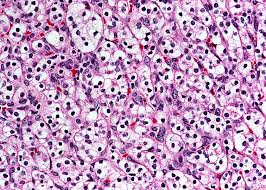

In [38]:
image

In [39]:
text

'<|Question|> What is your final diagnosis?<|end_of_text|>'

In [40]:
res

['<|Answer|> The final diagnosis is renal cell carcinoma, clear cell type. Grade 4 with large nucleoli and high grade nucleoli is visible in some areas of the tumor. A few foci contain prominent nucleoli, raising the possibility of grade 5 (poorly cohesive) RCC. Tumor growth appears somewhat nested/organoid but tends to fill the space more than true nests. Delicate arborizing thin walled venules']

In [24]:
answer

'yes'

In [1]:
!nvidia-smi

Wed Apr 17 21:53:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:4B:00.0 Off |                    0 |
| N/A   26C    P0              52W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--